In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import torch

In [2]:
conn = sqlite3.connect('fantasy_football_data.db')

In [3]:
pd.read_sql('SELECT * FROM player_stats', conn)

,Player,Tm,FantPos,Age,G,GS,Cmp,Pass_Att,Pass_Yds,Pass_TD,...,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank,Year
0,Antonio Brown,PIT,WR,27.0,16.0,16.0,0.0,0.0,0.0,0.0,...,2.0,0.0,252.0,388.2,393.2,320.2,125.0,1.0,1.0,2015
1,Devonta Freeman,ATL,RB,23.0,15.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,243.0,316.4,324.4,279.9,120.0,1.0,2.0,2015
2,Julio Jones,ATL,WR,26.0,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,239.0,375.1,379.1,307.1,111.0,2.0,3.0,2015
3,Adrian Peterson,MIN,RB,30.0,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,231.0,260.7,269.7,245.7,107.0,2.0,4.0,2015
4,Cam Newton,CAR,QB,26.0,16.0,16.0,296.0,495.0,3837.0,35.0,...,0.0,0.0,389.0,389.1,409.1,399.1,105.0,1.0,5.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,Kendre Miller,NOR,RB,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
5929,Keaton Mitchell,BAL,RB,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
5930,D'Onta Foreman,CLE,RB,28.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
5931,Dylan Laube,LVR,RB,25.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024


In [4]:
# this query shows a players stats from the year before and then how many fantasy points (PPR) they scored the next year
# I'm using PPR because that's the scoring system my fantasy league uses
# I want to train a model to use stats from the previous season to predict how well the players will perform the next season
# hopefully this will help me prepare for my fantasy football drafts this upcoming season
player_stats = pd.read_sql('''
            SELECT 
                p2.Player, p2.Year, p2.Tm, p2.FantPos, p2.Age, p1.G, p1.GS, p1.Cmp, p1.Pass_Att, p1.Pass_Yds, 
                p1.Pass_TD, p1.Int, p1.Rush_Att, p1.Rush_Yds, p1."Y/A", p1.Rush_TD, p1.Tgt, p1.Rec, p1.Rec_Yds, 
                p1."Y/R", p1.Rec_TD, p1.Fmb, p1.FL, p1.Tot_TD, p1."2PM", p1."2PP", p2.PPR, p1.Tm as "Tm_Last_Yr"
            FROM 
                player_stats p1 
            JOIN 
                player_stats p2 
            ON 
                p1.Year = (p2.Year - 1) and p1.Player = p2.Player'''
        , conn)
# I thought changing teams would be a useful feature
player_stats['Changed_Teams'] = np.where(player_stats['Tm'] != player_stats['Tm_Last_Yr'], 1, 0)
# player_stats = player_stats[player_stats['Year'] != 2024]
player_stats

,Player,Year,Tm,FantPos,Age,G,GS,Cmp,Pass_Att,Pass_Yds,...,Y/R,Rec_TD,Fmb,FL,Tot_TD,2PM,2PP,PPR,Tm_Last_Yr,Changed_Teams
0,Antonio Brown,2016,PIT,WR,28.0,16.0,16.0,0.0,0.0,0.0,...,13.49,10.0,3.0,2.0,11.0,2.0,0.0,307.3,PIT,0
1,Devonta Freeman,2016,ATL,RB,24.0,15.0,13.0,0.0,0.0,0.0,...,7.92,3.0,3.0,2.0,14.0,0.0,0.0,284.1,ATL,0
2,Julio Jones,2016,ATL,WR,27.0,16.0,16.0,0.0,0.0,0.0,...,13.76,8.0,3.0,1.0,9.0,0.0,0.0,259.9,ATL,0
3,Adrian Peterson,2016,MIN,RB,31.0,16.0,16.0,0.0,0.0,0.0,...,7.40,0.0,7.0,3.0,11.0,0.0,0.0,9.0,MIN,0
4,Cam Newton,2016,CAR,QB,27.0,16.0,16.0,296.0,495.0,3837.0,...,0.00,0.0,5.0,4.0,10.0,0.0,0.0,254.3,CAR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,Greg Dulcich,2024,DEN,TE,24.0,2.0,1.0,0.0,0.0,0.0,...,8.33,0.0,0.0,0.0,0.0,0.0,0.0,NaN,DEN,0
3963,Jalen Nailor,2024,MIN,WR,25.0,6.0,1.0,0.0,0.0,0.0,...,9.67,0.0,0.0,0.0,0.0,0.0,0.0,NaN,MIN,0
3964,Antoine Green,2024,DET,WR,25.0,9.0,0.0,0.0,0.0,0.0,...,2.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,DET,0
3965,Deneric Prince,2024,KAN,RB,24.0,2.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,KAN,0


In [5]:
# checking that the query did what it was supposed to
# the query returned Browns's stats from 2015 and his fantasy points from 2016 so it worked as expected
print(player_stats.iloc[0])
print(pd.read_sql('SELECT * FROM player_stats WHERE PLAYER IS "Antonio Brown" AND YEAR IN (2017, 2018)', conn))

Player           Antonio Brown
Year                      2016
Tm                         PIT
FantPos                     WR
Age                       28.0
G                         16.0
GS                        16.0
Cmp                        0.0
Pass_Att                   0.0
Pass_Yds                   0.0
Pass_TD                    0.0
Int                        0.0
Rush_Att                   3.0
Rush_Yds                  28.0
Y/A                       9.33
Rush_TD                    0.0
Tgt                      193.0
Rec                      136.0
Rec_Yds                 1834.0
Y/R                      13.49
Rec_TD                    10.0
Fmb                        3.0
FL                         2.0
Tot_TD                    11.0
2PM                        2.0
2PP                        0.0
PPR                      307.3
Tm_Last_Yr                 PIT
Changed_Teams                0
Name: 0, dtype: object
          Player   Tm FantPos   Age     G    GS  Cmp  Pass_Att  Pass_Yds  \
0 

# EDA

<function matplotlib.pyplot.show(close=None, block=None)>

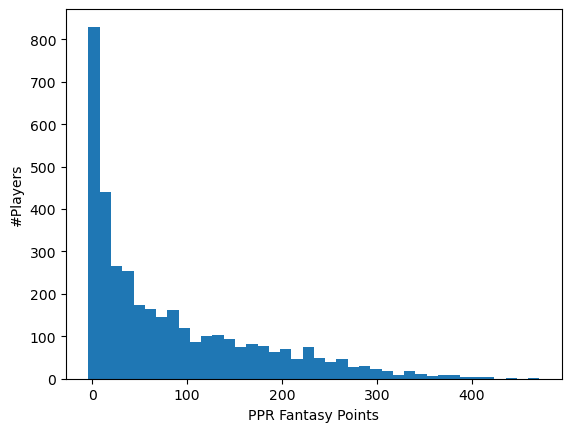

In [6]:
# the data is very heavily skewed
plt.hist(player_stats['PPR'], bins = 40)
plt.xlabel('PPR Fantasy Points')
plt.ylabel('#Players')
plt.show

In [7]:
# creating a correlation matrix to see which stats best correlate with PPR points
corr_mat = player_stats.drop(['Player', 'Year', 'Tm', 'FantPos', 'Tm_Last_Yr'], axis=1).corr()

<Axes: >

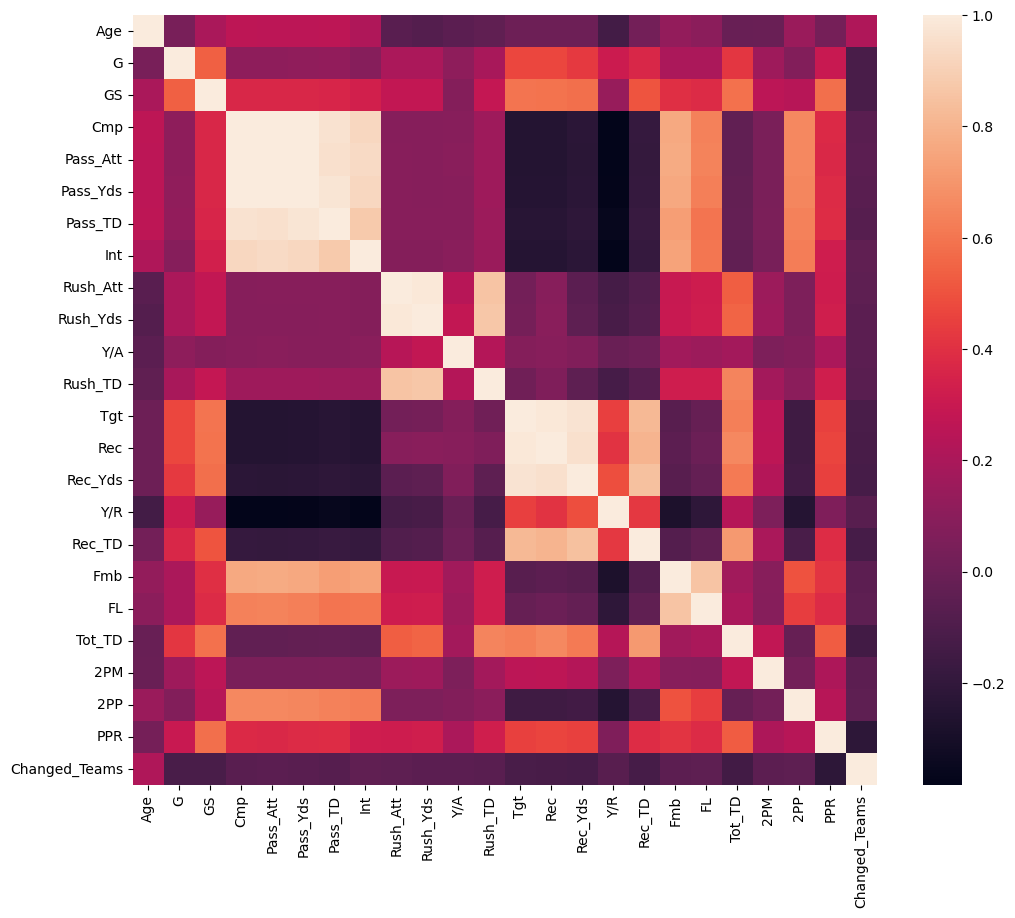

In [8]:
# creating a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat)

In [9]:
# printing out the stats in order of best correlation with PPR points, nothing really unexpected
# I was initially surprised that age had no correlation with points but when I thought about it it made sense
# age should not be linearly correlated with PPR points because it is expected that players will get better their first few years in the league and then start to decline at an older age
# the NFL does not have a lot of old players so most players do not reach the age where they start to physically decline, and the ones that do are normally the best players in the league
# also the NFL has a lot of young players that don't get that much playing time
corr_mat['PPR'].sort_values(ascending=False)

PPR              1.000000
GS               0.578841
Tot_TD           0.527025
Rec              0.464115
Rec_Yds          0.452676
Tgt              0.450291
Fmb              0.413499
Rec_TD           0.389066
Pass_TD          0.387659
FL               0.381702
Pass_Yds         0.380269
Cmp              0.373822
Pass_Att         0.371757
Rush_Yds         0.329539
Rush_TD          0.329010
Int              0.322034
Rush_Att         0.315158
G                0.302207
2PP              0.239986
2PM              0.206281
Y/A              0.200553
Y/R              0.059528
Age              0.029566
Changed_Teams   -0.219662
Name: PPR, dtype: float64

In [10]:
player_features = player_stats.drop(['Player', 'Tm', 'FantPos', 'Age', 'PPR', 'Tm_Last_Yr', '2PP', '2PM'], axis=1)
# dropped 2 point stats because 2 point plays are not a big part of the game and therefore are pretty useless stats 
player_info = player_stats[['Player', 'Year', 'Tm', 'FantPos', 'Age']]
player_PPR = player_stats[['Year', 'PPR']]

# Linear Regression

In [11]:
# first I'm going to see how well linear regression fits the data
from sklearn.linear_model import LinearRegression

In [12]:
# prepping the data for machine learning by sorting by year
player_features_2022 = player_features[player_features['Year']==2022].drop('Year', axis=1)
player_PPR_2022 = player_PPR[player_PPR['Year']==2022].drop('Year', axis=1)
player_info_2022 = player_info[player_info['Year']==2022]
player_features_2023 = player_features[player_features['Year']==2023].drop('Year', axis=1)
player_PPR_2023 = player_PPR[player_PPR['Year']==2023].drop('Year', axis=1)
player_info_2023 = player_info[player_info['Year']==2023]

In [13]:
player_features_2022.head()

,G,GS,Cmp,Pass_Att,Pass_Yds,Pass_TD,Int,Rush_Att,Rush_Yds,Y/A,Rush_TD,Tgt,Rec,Rec_Yds,Y/R,Rec_TD,Fmb,FL,Tot_TD,Changed_Teams
2746,17.0,17.0,0.0,0.0,0.0,0.0,0.0,332.0,1811.0,5.45,18.0,51.0,40.0,360.0,9.00,2.0,4.0,2.0,20.0,0
2747,17.0,17.0,0.0,1.0,0.0,0.0,0.0,4.0,18.0,4.50,0.0,191.0,145.0,1947.0,13.43,16.0,0.0,0.0,16.0,0
2748,16.0,15.0,1.0,2.0,24.0,1.0,0.0,59.0,365.0,6.19,8.0,121.0,77.0,1405.0,18.25,6.0,4.0,2.0,14.0,0
2749,17.0,17.0,409.0,646.0,4407.0,36.0,15.0,122.0,763.0,6.25,6.0,0.0,0.0,0.0,0.00,0.0,8.0,3.0,6.0,0
2750,16.0,16.0,0.0,0.0,0.0,0.0,0.0,206.0,911.0,4.42,12.0,94.0,70.0,647.0,9.24,8.0,4.0,3.0,20.0,0


In [14]:
player_PPR_2022.head()

,PPR
2746,146.4
2747,201.4
2748,168.4
2749,395.5
2750,372.7


In [15]:
player_info_2022.head()

,Player,Year,Tm,FantPos,Age
2746,Jonathan Taylor,2022,IND,RB,23.0
2747,Cooper Kupp,2022,LAR,WR,29.0
2748,Deebo Samuel,2022,SFO,WR,26.0
2749,Josh Allen,2022,BUF,QB,26.0
2750,Austin Ekeler,2022,LAC,RB,27.0


In [16]:
# fitting the data on 2022 and testing on 2023
lr = LinearRegression()
lr.fit(player_features_2022, player_PPR_2022)

LinearRegression()

In [17]:
lr.score(player_features_2022, player_PPR_2022)

0.6477889541813621

In [18]:
lr.score(player_features_2023, player_PPR_2023) 

0.5601163065428336

In [19]:
# saving the result as a dataframe
result = pd.DataFrame({'Actual PPR': player_PPR_2023['PPR'], 'Predicted PPR': lr.predict(player_features_2023).flatten()})
result = pd.concat([player_info_2023, result], axis=1)
result['Predicted Rank'] = result['Predicted PPR'].rank(ascending=False, method='min').astype(int)
result['Actual Rank'] = result['Actual PPR'].rank(ascending=False, method='min').astype(int)
result.sort_values('Predicted Rank', inplace=True)
result

,Player,Year,Tm,FantPos,Age,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
3255,Patrick Mahomes,2023,KAN,QB,28.0,280.2,312.728022,1,17
3261,Josh Allen,2023,BUF,QB,27.0,392.6,303.136646,2,2
3266,Jalen Hurts,2023,PHI,QB,25.0,356.8,301.307976,3,5
3307,Daniel Jones,2023,NYG,QB,26.0,57.0,298.554892,4,207
3259,Justin Jefferson,2023,MIN,WR,24.0,202.2,294.192867,5,64
...,...,...,...,...,...,...,...,...,...
3721,Matthew Slater,2023,NWE,WR,38.0,0.0,-6.521014,475,420
3668,D'Ernest Johnson,2023,JAX,RB,27.0,34.8,-6.774079,476,261
3654,James Proche,2023,CLE,WR,27.0,-2.0,-10.204239,477,478
3676,Stephen Anderson,2023,LAC,TE,30.0,0.0,-15.540251,478,420


In [20]:
result.sort_values('Actual Rank')

,Player,Year,Tm,FantPos,Age,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
3270,CeeDee Lamb,2023,DAL,WR,24.0,403.2,250.783084,19,1
3261,Josh Allen,2023,BUF,QB,27.0,392.6,303.136646,2,2
3257,Christian McCaffrey,2023,SFO,RB,27.0,391.3,275.677125,9,3
3265,Tyreek Hill,2023,MIA,WR,29.0,376.4,281.287741,7,4
3266,Jalen Hurts,2023,PHI,QB,25.0,356.8,301.307976,3,5
...,...,...,...,...,...,...,...,...,...
3727,Logan Woodside,2023,ATL,QB,28.0,-0.3,32.299248,324,475
3621,Nathan Peterman,2023,CHI,QB,29.0,-0.4,37.344591,298,476
3583,Kyle Allen,2023,BUF,QB,27.0,-1.3,32.509261,319,477
3654,James Proche,2023,CLE,WR,27.0,-2.0,-10.204239,477,478


Text(0.5, 1.0, '2023')

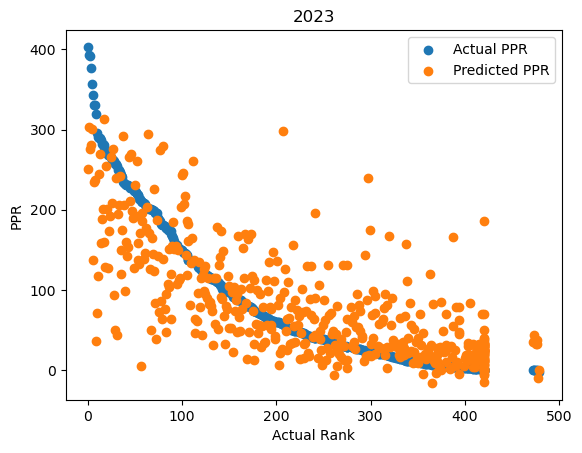

In [21]:
# plotting the data
plt.scatter(result['Actual Rank'], result['Actual PPR'])
plt.scatter(result['Actual Rank'], result['Predicted PPR'])
plt.xlabel('Actual Rank')
plt.ylabel('PPR')
plt.legend(('Actual PPR', 'Predicted PPR'))
plt.title('2023')

In [22]:
# sorting by position
qb_result = result[result['FantPos']=='QB']
wr_result = result[result['FantPos']=='WR']
rb_result = result[result['FantPos']=='RB']
te_result = result[result['FantPos']=='TE']

Text(0.5, 1.0, 'QBs')

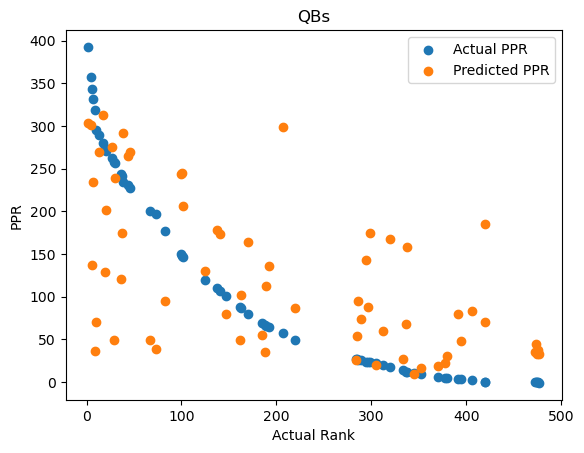

In [23]:
plt.scatter(qb_result['Actual Rank'], qb_result['Actual PPR'])
plt.scatter(qb_result['Actual Rank'], qb_result['Predicted PPR'])
plt.xlabel('Actual Rank')
plt.ylabel('PPR')
plt.legend(('Actual PPR', 'Predicted PPR'))
plt.title('QBs')

Text(0.5, 1.0, 'WRs')

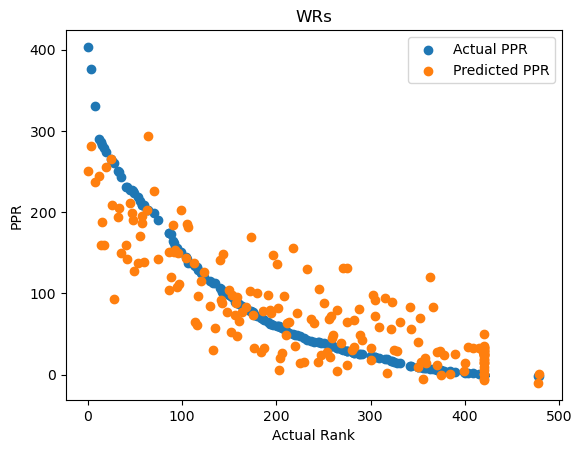

In [24]:
plt.scatter(wr_result['Actual Rank'], wr_result['Actual PPR'])
plt.scatter(wr_result['Actual Rank'], wr_result['Predicted PPR'])
plt.xlabel('Actual Rank')
plt.ylabel('PPR')
plt.legend(('Actual PPR', 'Predicted PPR'))
plt.title('WRs')

Text(0.5, 1.0, 'RBs')

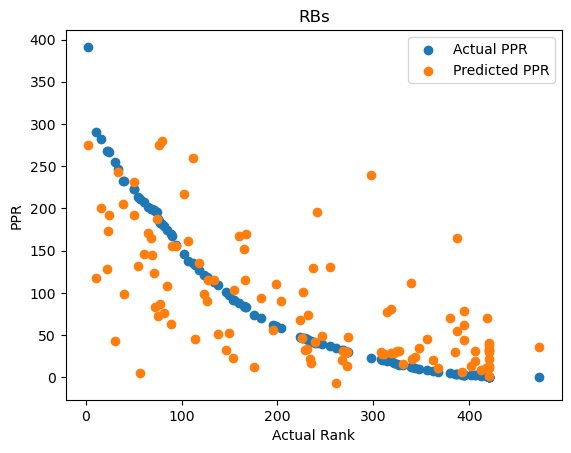

In [25]:
plt.scatter(rb_result['Actual Rank'], rb_result['Actual PPR'])
plt.scatter(rb_result['Actual Rank'], rb_result['Predicted PPR'])
plt.xlabel('Actual Rank')
plt.ylabel('PPR')
plt.legend(('Actual PPR', 'Predicted PPR'))
plt.title('RBs')

Text(0.5, 1.0, 'TEs')

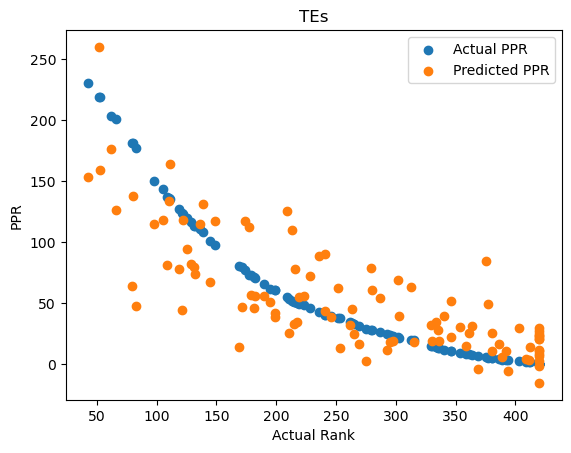

In [26]:
plt.scatter(te_result['Actual Rank'], te_result['Actual PPR'])
plt.scatter(te_result['Actual Rank'], te_result['Predicted PPR'])
plt.xlabel('Actual Rank')
plt.ylabel('PPR')
plt.legend(('Actual PPR', 'Predicted PPR'))
plt.title('TEs')

The initial predictions were not very good but that's okay because there's a lot of room for imporvement. By position, WR and TE predictions performed better than QB and RB predictions. I don't know if this means anything but I think later I might try to predict each position group seperately. I have a lot of ideas on how to improve the model but first I'm going to start with using more years of player stats.

In [27]:
# query that returns average stats from the last 2 seasons
player_stats2 = pd.read_sql('''
        SELECT 
            Player, Year, Tm, FantPos, Age, 
            AVG(G) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS G,
            AVG(GS) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS GS,
            AVG(Cmp) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Cmp,
            AVG(Pass_Att) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Pass_Att,
            AVG(Pass_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Pass_Yds,
            AVG(Pass_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Pass_TD,
            AVG(Int) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Int,
            AVG(Rush_Att) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Rush_Att,
            AVG(Rush_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Rush_Yds,
            AVG("Y/A") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Y/A",
            AVG(Rush_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Rush_TD,
            AVG(Tgt) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Tgt,
            AVG(Rec) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Rec,
            AVG(Rec_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Rec_Yds,
            AVG("Y/R") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Y/R",
            AVG(Rec_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Rec_TD,
            AVG(Fmb) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Fmb,
            AVG(FL) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS FL,
            AVG(Tot_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS Tot_TD,
            AVG("2PM") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "2PM",
            AVG("2PP") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "2PP", 
            PPR,
            LAG(Tm, 1) OVER (PARTITION BY Player ORDER BY Year) AS Tm_Last_Yr
        FROM
            player_stats'''
    , conn)
player_stats2['Changed_Teams'] = np.where(player_stats2['Tm'] != player_stats2['Tm_Last_Yr'], 1, 0)
# the null values are from players in their first year in the league
# I'm dropping these rows because if it's a players first year in the league I can't use their previous years NFL stats to predict how they'll perform
# later I'm going to try and predict how rookies will do from their college stats
player_stats2.dropna(subset=['G'],inplace=True)
player_stats2.head()

,Player,Year,Tm,FantPos,Age,G,GS,Cmp,Pass_Att,Pass_Yds,...,Y/R,Rec_TD,Fmb,FL,Tot_TD,2PM,2PP,PPR,Tm_Last_Yr,Changed_Teams
1,A.J. Brown,2020,TEN,WR,23.0,16.0,11.0,0.0,0.0,0.0,...,20.210,8.0,1.0,0.0,9.0,0.0,0.0,247.5,TEN,0
2,A.J. Brown,2021,TEN,WR,24.0,15.0,11.5,0.0,0.0,0.0,...,17.785,9.5,1.5,0.5,10.5,0.0,0.0,180.9,TEN,0
3,A.J. Brown,2022,PHI,WR,25.0,13.5,12.5,0.0,1.0,0.0,...,14.575,8.0,1.0,0.5,8.5,0.0,0.0,299.6,TEN,1
4,A.J. Brown,2023,PHI,WR,26.0,15.0,14.5,0.0,1.0,0.0,...,15.395,8.0,1.0,1.0,8.0,0.0,0.0,289.6,PHI,0
5,A.J. Brown,2024,PHI,WR,27.0,17.0,16.5,0.0,0.0,0.0,...,15.370,9.0,2.0,2.0,9.0,0.0,0.0,NaN,PHI,0


In [28]:
# checking to make sure the query worked
# this query returns some of AJ Brown's average stats from 2021 and 2022
# these stats should match up with the stats in AJ Brown's 2023 row above which it does
pd.read_sql('SELECT AVG(Rec), AVG(Rec_Yds), AVG(Rec_TD) FROM player_stats WHERE Player IS "A.J. Brown" AND YEAR IN (2021, 2022)', conn)

,AVG(Rec),AVG(Rec_Yds),AVG(Rec_TD)
0,75.5,1182.5,8.0


In [29]:
# also making sure that the players info (Tm, FantPos, Age) also matches up 
pd.read_sql('SELECT * FROM player_stats WHERE Player is "A.J. Brown" AND Year IS 2023', conn)

,Player,Tm,FantPos,Age,G,GS,Cmp,Pass_Att,Pass_Yds,Pass_TD,...,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank,Year
0,A.J. Brown,PHI,WR,26.0,17.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,184.0,289.6,294.6,236.6,51.0,8.0,20.0,2023


In [30]:
# query that returns average stats from the last 2 seasons
# same logic as the query that averaged stats from the last 2 seasons
player_stats3 = pd.read_sql('''
        SELECT 
            Player, Year, Tm, FantPos, Age, 
            AVG(G) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS G,
            AVG(GS) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS GS,
            AVG(Cmp) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Cmp,
            AVG(Pass_Att) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Pass_Att,
            AVG(Pass_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Pass_Yds,
            AVG(Pass_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Pass_TD,
            AVG(Int) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Int,
            AVG(Rush_Att) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Rush_Att,
            AVG(Rush_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Rush_Yds,
            AVG("Y/A") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS "Y/A",
            AVG(Rush_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Rush_TD,
            AVG(Tgt) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Tgt,
            AVG(Rec) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Rec,
            AVG(Rec_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Rec_Yds,
            AVG("Y/R") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS "Y/R",
            AVG(Rec_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Rec_TD,
            AVG(Fmb) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Fmb,
            AVG(FL) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS FL,
            AVG(Tot_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS Tot_TD,
            AVG("2PM") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS "2PM",
            AVG("2PP") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 3 PRECEDING AND 1 PRECEDING) AS "2PP", 
            PPR,
            LAG(Tm, 1) OVER (PARTITION BY Player ORDER BY Year) AS Tm_Last_Yr
        FROM
            player_stats'''
    , conn)
player_stats3['Changed_Teams'] = np.where(player_stats3['Tm'] != player_stats3['Tm_Last_Yr'], 1, 0)
player_stats3.dropna(subset=['G'],inplace=True)
player_stats3.head()

,Player,Year,Tm,FantPos,Age,G,GS,Cmp,Pass_Att,Pass_Yds,...,Y/R,Rec_TD,Fmb,FL,Tot_TD,2PM,2PP,PPR,Tm_Last_Yr,Changed_Teams
1,A.J. Brown,2020,TEN,WR,23.0,16.000000,11.000000,0.0,0.000000,0.0,...,20.210000,8.000000,1.000000,0.000000,9.000000,0.0,0.0,247.5,TEN,0
2,A.J. Brown,2021,TEN,WR,24.0,15.000000,11.500000,0.0,0.000000,0.0,...,17.785000,9.500000,1.500000,0.500000,10.500000,0.0,0.0,180.9,TEN,0
3,A.J. Brown,2022,PHI,WR,25.0,14.333333,12.000000,0.0,0.666667,0.0,...,16.453333,8.000000,1.000000,0.333333,8.666667,0.0,0.0,299.6,TEN,1
4,A.J. Brown,2023,PHI,WR,26.0,14.666667,13.666667,0.0,0.666667,0.0,...,15.383333,9.000000,1.333333,1.000000,9.333333,0.0,0.0,289.6,PHI,0
5,A.J. Brown,2024,PHI,WR,27.0,15.666667,15.333333,0.0,0.666667,0.0,...,14.843333,7.666667,1.333333,1.333333,7.666667,0.0,0.0,NaN,PHI,0


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [32]:
# custom cross validation function to see whether 1, 2, or 3 years of stats performs the best
# I'm custom function because I'm not doing a random cross variation, I'm using stats from the year(s) before to predict the next year
def cv(df, years, model):
    result = []
    for i in range(len(years)-1):
        train_year = years[i]
        test_year = years[i+1]
        
        # features and target
        features = df.drop(['Player', 'Tm', 'FantPos', 'Age', 'PPR', 'Tm_Last_Yr', '2PP', '2PM'], axis=1)
        PPR = df[['Year', 'PPR']]
        
        # train data
        features_train = features[features['Year']==train_year].drop('Year', axis=1)
        PPR_train = PPR[PPR['Year']==train_year].drop('Year', axis=1)
        
        # test data
        features_test = features[features['Year']==test_year].drop('Year', axis=1)
        PPR_test = PPR[PPR['Year']==test_year].drop('Year', axis=1)
        
        # fitting the model and making predictions
        m = model
        m.fit(features_train, PPR_train.values.flatten())
        train_predict = m.predict(features_train)
        test_predict = m.predict(features_test)
        result.append((mean_squared_error(PPR_train, train_predict), mean_squared_error(PPR_test, test_predict)))
    return np.array(result)

In [33]:
# scaled version of the above function because other models need scaled
# also makes it easier to compare
def cv_scaled(df, years, model):
    result = []
    for i in range(len(years)-1):
        train_year = years[i]
        test_year = years[i+1]
        
        # features and target
        df.dropna(inplace=True)
        features = df.drop(['Player', 'Tm', 'FantPos', 'Age', 'PPR', 'Tm_Last_Yr', '2PP', '2PM'], axis=1)
        PPR = df[['Year', 'PPR']]
        
        # scaling the data
        scaler = StandardScaler()
        features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
        features['Year'] = df['Year']
        features['Changed_Teams'] = df['Changed_Teams']
        PPR = pd.DataFrame(scaler.fit_transform(PPR), columns=PPR.columns)
        PPR['Year'] = df['Year']
        
        # train data
        features_train = features[features['Year']==train_year].drop('Year', axis=1).reset_index(drop=True)
        PPR_train = PPR[PPR['Year']==train_year].drop('Year', axis=1).reset_index(drop=True)
        
        # test data
        features_test = features[features['Year']==test_year].drop('Year', axis=1).reset_index(drop=True)
        PPR_test = PPR[PPR['Year']==test_year].drop('Year', axis=1).reset_index(drop=True)
        
        # fitting the model and making predictions
        m = model
        m.fit(features_train, PPR_train.values.flatten())
        train_predict = m.predict(features_train)
        test_predict = m.predict(features_test)
        result.append((mean_squared_error(PPR_train, train_predict), mean_squared_error(PPR_test, test_predict)))
    return np.array(result)

In [34]:
# function to print out the errors
def print_cv(error, title):
    print(title)
    print(f'Train MSE: {error[:,0]}')
    print(f'Test MSE: {error[:,1]}')
    print(f'Mean Train MSE: {np.mean(error[:,0])}')
    print(f'Mean Test MSE: {np.mean(error[:,1])}\n')
    return

In [35]:
player_stats2[player_stats2['Year']==2016].isnull().sum()
player_stats[player_stats.isnull().any(axis=1)]

,Player,Year,Tm,FantPos,Age,G,GS,Cmp,Pass_Att,Pass_Yds,...,Y/R,Rec_TD,Fmb,FL,Tot_TD,2PM,2PP,PPR,Tm_Last_Yr,Changed_Teams
3734,Christian McCaffrey,2024,SFO,RB,28.0,16.0,16.0,0.0,0.0,0.0,...,8.42,7.0,3.0,2.0,21.0,0.0,0.0,NaN,SFO,0
3735,CeeDee Lamb,2024,DAL,WR,25.0,17.0,17.0,0.0,0.0,0.0,...,12.96,12.0,3.0,2.0,14.0,1.0,0.0,NaN,DAL,0
3736,Josh Allen,2024,Bills,QB,28.0,17.0,17.0,385.0,579.0,4306.0,...,0.00,0.0,7.0,4.0,15.0,0.0,3.0,NaN,BUF,1
3737,Tyreek Hill,2024,MIA,WR,30.0,16.0,16.0,0.0,0.0,0.0,...,15.12,13.0,1.0,1.0,13.0,0.0,0.0,NaN,MIA,0
3738,Jalen Hurts,2024,PHI,QB,26.0,17.0,17.0,352.0,538.0,3858.0,...,0.00,0.0,9.0,5.0,15.0,0.0,0.0,NaN,PHI,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3962,Greg Dulcich,2024,DEN,TE,24.0,2.0,1.0,0.0,0.0,0.0,...,8.33,0.0,0.0,0.0,0.0,0.0,0.0,NaN,DEN,0
3963,Jalen Nailor,2024,MIN,WR,25.0,6.0,1.0,0.0,0.0,0.0,...,9.67,0.0,0.0,0.0,0.0,0.0,0.0,NaN,MIN,0
3964,Antoine Green,2024,DET,WR,25.0,9.0,0.0,0.0,0.0,0.0,...,2.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,DET,0
3965,Deneric Prince,2024,KAN,RB,24.0,2.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,KAN,0


In [36]:
cv_years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
print_cv(cv_scaled(player_stats, cv_years, LinearRegression()), '1 year of stats')
print_cv(cv_scaled(player_stats2, cv_years, LinearRegression()), '2 years of stats')
print_cv(cv_scaled(player_stats3, cv_years, LinearRegression()), '3 years of stats')

1 year of stats
Train MSE: [0.49489203 0.34472303 0.42899682 0.40131524 0.44567952 0.39963231]
Test MSE: [0.42434336 0.53897    0.57049543 0.55825771 0.43364811 0.38119139]
Mean Train MSE: 0.4192064937557431
Mean Test MSE: 0.48448433237040595

2 years of stats
Train MSE: [0.37347306 0.49080227 0.40521051 0.41248033 0.32056261 0.37577435]
Test MSE: [0.58128835 0.53364961 0.56481696 0.39752204 0.42491715 0.40629002]
Mean Train MSE: 0.3963838540914875
Mean Test MSE: 0.48474735528262486

3 years of stats
Train MSE: [0.35459368 0.51431448 0.39418681 0.40232476 0.33984551 0.37110965]
Test MSE: [0.60485916 0.53200707 0.57103464 0.4053989  0.42888359 0.46954952]
Mean Train MSE: 0.39606248093462765
Mean Test MSE: 0.501955477599983



The error is similar and surprisingly 1 year performed the best, but I'm going to go with 3 years of stats because I think averaging more years will help smooth out the model. I could potentially add more years but I think 3 is a solid choice because football is very volatile and a players last 3 years should represent them pretty well.

# Advanced models

In [37]:
# trying some advanced models to see if it improves anything
from xgboost import XGBRegressor

In [38]:
xgb = XGBRegressor(learning_rate=0.01,
                       n_estimators=100,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [39]:
# my laptop can't run XGBoost for some reason it keeps crashing
# print_cv(cv_scaled(player_stats3, cv_years, xgb))

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.001,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

In [42]:
print_cv(cv_scaled(player_stats3, cv_years, gbr), 'Gradient Boost Regressor')

Gradient Boost Regressor
Train MSE: [0.23344414 0.32350578 0.25775795 0.24349559 0.19119774 0.24566825]
Test MSE: [0.59948837 0.52619693 0.53985065 0.42414952 0.46219696 0.43333791]
Mean Train MSE: 0.2491782428400486
Mean Test MSE: 0.4975367243883246



In [43]:
# features, target, and info
player_features3 = player_stats3.drop(['Player', 'Tm', 'FantPos', 'Age', 'PPR', 'Tm_Last_Yr', '2PP', '2PM'], axis=1)
player_info3 = player_stats3[['Player', 'Year', 'Tm', 'FantPos', 'Age']]
player_PPR3 = player_stats3[['Year', 'PPR']]

# scaling the data
scaler = StandardScaler()
player_features3 = pd.DataFrame(scaler.fit_transform(player_features3), columns=player_features3.columns)
player_features3['Year'] = player_stats3['Year']
player_features3['Changed_Teams'] = player_features3['Changed_Teams']
player_PPR3 = pd.DataFrame(scaler.fit_transform(player_PPR3), columns=player_PPR3.columns)
player_PPR3['Year'] = player_stats3['Year']

In [44]:
# train and test data
player_features3_2022 = player_features3[player_features3['Year']==2022].drop('Year', axis=1)
player_PPR3_2022 = player_PPR3[player_PPR3['Year']==2022].drop('Year', axis=1)
player_info3_2022 = player_info3[player_info3['Year']==2022]
player_features3_2023 = player_features3[player_features3['Year']==2023].drop('Year', axis=1)
player_PPR3_2023 = player_PPR3[player_PPR3['Year']==2023].drop('Year', axis=1)
player_info3_2023 = player_info3[player_info3['Year']==2023]

In [45]:
# pytorch neural networks
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [46]:
# setting up the neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [47]:
# train and test sets, pytorch data needs to be in tensors
X_train = torch.tensor(player_features3_2022.values, dtype=torch.float32)
y_train = torch.tensor(player_PPR3_2022.values, dtype=torch.float32)
X_test = torch.tensor(player_features3_2023.values, dtype=torch.float32)
y_test = torch.tensor(player_PPR3_2023.values, dtype=torch.float32)

In [48]:
# initializing the model
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training the model
num_epochs = 1000
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.3336
Epoch [200/1000], Loss: 0.2936
Epoch [300/1000], Loss: 0.2646
Epoch [400/1000], Loss: 0.2313
Epoch [500/1000], Loss: 0.1987
Epoch [600/1000], Loss: 0.1687
Epoch [700/1000], Loss: 0.1410
Epoch [800/1000], Loss: 0.1191
Epoch [900/1000], Loss: 0.1009
Epoch [1000/1000], Loss: 0.0850


In [49]:
# evaluating the model
model.eval()
with torch.no_grad():  # No need to compute gradients for evaluation
    train_predict = model(X_train)
    test_predict = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
    test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 0.08490598946809769
Test MSE: 0.5693628191947937


Clearly the neural network is severely overfit and the gradient boost model had the same problem to a lesser extent. Both models could be tuned better but I don't think there's a point because they're not fitting the data well. Other options need to be explored first. I want to try to splitting up the players by position because then there will be less features because each position has different features that are important.

In [50]:
# splitting up by position
qb_stats = player_stats3[player_stats3['FantPos']=='QB'].reset_index(drop=True)
wr_stats = player_stats3[player_stats3['FantPos']=='WR'].reset_index(drop=True)
rb_stats = player_stats3[player_stats3['FantPos']=='RB'].reset_index(drop=True)
te_stats = player_stats3[player_stats3['FantPos']=='TE'].reset_index(drop=True)

# running initial eda and tests on qbs
qb_stats.head()

,Player,Year,Tm,FantPos,Age,G,GS,Cmp,Pass_Att,Pass_Yds,...,Y/R,Rec_TD,Fmb,FL,Tot_TD,2PM,2PP,PPR,Tm_Last_Yr,Changed_Teams
0,A.J. McCarron,2016,CIN,QB,26.0,7.000000,3.000000,79.000000,119.000000,854.000000,...,0.0,0.0,1.000000,1.000000,0.000000,0.0,0.0,0.0,CIN,0
1,A.J. McCarron,2017,CIN,QB,27.0,4.000000,1.500000,39.500000,59.500000,427.000000,...,0.0,0.0,0.500000,0.500000,0.000000,0.0,0.0,2.6,CIN,0
2,A.J. McCarron,2018,OAK,QB,28.0,3.666667,1.000000,28.666667,44.333333,306.666667,...,0.0,0.0,0.333333,0.333333,0.000000,0.0,0.0,0.1,CIN,1
3,A.J. McCarron,2019,HOU,QB,29.0,2.000000,0.000000,2.666667,5.666667,24.666667,...,0.0,0.0,0.333333,0.000000,0.000000,0.0,0.0,16.9,OAK,1
4,A.J. McCarron,2020,HOU,QB,30.0,2.333333,0.333333,9.666667,18.000000,99.666667,...,0.0,0.0,0.333333,0.000000,0.333333,0.0,0.0,0.8,HOU,0


<Axes: >

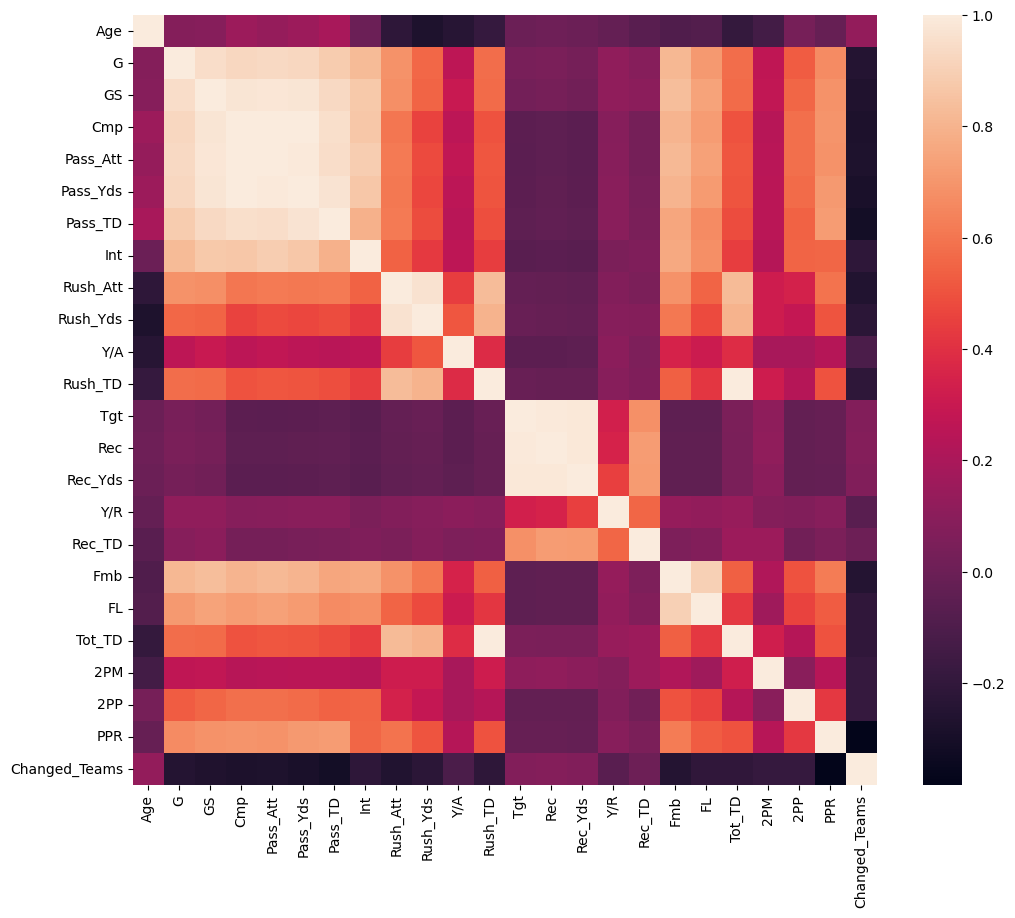

In [51]:
# heatmap of correlation matrix
corr_mat = qb_stats.drop(['Player', 'Year', 'Tm', 'FantPos', 'Tm_Last_Yr'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat)

In [52]:
# stats with highest correlation to PPR
# higher correlation scores than when the players were all together
corr_mat['PPR'].sort_values(ascending=False)

PPR              1.000000
Pass_TD          0.722675
Pass_Yds         0.708632
Cmp              0.693330
GS               0.691419
Pass_Att         0.689794
G                0.668231
Fmb              0.617918
Rush_Att         0.592670
Int              0.553495
FL               0.525791
Rush_Yds         0.504016
Rush_TD          0.498843
Tot_TD           0.498515
2PP              0.425970
2PM              0.238427
Y/A              0.236645
Y/R              0.088567
Rec_TD           0.049440
Tgt             -0.017980
Age             -0.019250
Rec             -0.020579
Rec_Yds         -0.026433
Changed_Teams   -0.383334
Name: PPR, dtype: float64

In [53]:
# picking the features for qbs (passing and rushing stats)
qb_features = qb_stats[['Year', 'G', 'GS', 'Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Int', 'Rush_Att', 'Rush_Yds', 'Rush_TD', 'Changed_Teams']]
qb_info = qb_stats[['Player', 'Year', 'Tm', 'FantPos', 'Age']]
qb_PPR = qb_stats[['Year','PPR']]

# scaling the data
scaler = StandardScaler()
qb_features = pd.DataFrame(scaler.fit_transform(qb_features), columns=qb_features.columns)
scalerPPR = StandardScaler() # using a different scaler so I can unscale the data later
qb_PPR = pd.DataFrame(scalerPPR.fit_transform(qb_PPR['PPR'].values.reshape(-1,1)), columns=['PPR'])
qb_features['Year'] = qb_stats['Year']
qb_features['Changed_Teams'] = qb_stats['Changed_Teams']
qb_PPR['Year'] = qb_stats['Year']

qb_features.head()

,Year,G,GS,Cmp,Pass_Att,Pass_Yds,Pass_TD,Int,Rush_Att,Rush_Yds,Rush_TD,Changed_Teams
0,2016,-0.402505,-0.776984,-0.657518,-0.696656,-0.674495,-0.550293,-0.864474,-0.485417,-0.546897,-0.725323,0
1,2017,-0.976715,-1.024310,-0.945221,-0.978717,-0.944752,-0.821102,-1.074625,-0.733986,-0.642493,-0.725323,0
2,2018,-1.040516,-1.106752,-1.024127,-1.050615,-1.020914,-0.911372,-1.144675,-0.816843,-0.674358,-0.725323,1
3,2019,-1.359522,-1.271636,-1.213501,-1.233916,-1.199398,-1.091911,-1.284775,-0.947046,-0.742200,-0.725323,1
4,2020,-1.295721,-1.216675,-1.162515,-1.175449,-1.151929,-1.091911,-1.214725,-0.887863,-0.662023,-0.530669,0


In [54]:
# I thought about it and I realized I can just do normal cross validation instead of splitting up by year because each data point is independent
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error

In [55]:
# 12 fold cross validation
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [56]:
# linear regression all players together
lr = LinearRegression()
results = cross_validate(lr, player_features3.drop('Year', axis=1), player_PPR3['PPR'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.43588579 0.43359799 0.43743675 0.43659481 0.43235252 0.43395419
 0.42031502 0.43525305 0.43147549 0.43507728 0.43298467 0.42833346]
Test MSE: [0.40789171 0.43381804 0.38927547 0.39765179 0.44440456 0.42750569
 0.57948709 0.41266906 0.45617711 0.41702427 0.43680595 0.49113359]
Mean Train MSE: 0.4327717506318512
Mean Test MSE: 0.44115369387224446


In [57]:
# linear regression qbs only
results = cross_validate(lr, qb_features.drop('Year', axis=1), qb_PPR['PPR'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.38989913 0.4211658  0.39520796 0.42332245 0.42131154 0.39324685
 0.40053365 0.41857087 0.40234519 0.40459178 0.37315084 0.40828165]
Test MSE: [0.58855195 0.23947923 0.5309803  0.2129273  0.23870341 0.56219604
 0.49336493 0.27160809 0.45118593 0.43247268 0.79392798 0.39742898]
Mean Train MSE: 0.40430230961330055
Mean Test MSE: 0.4344022352272157


In [58]:
# gradient boosted regression qbs only
results = cross_validate(gbr, qb_features.drop('Year', axis=1), qb_PPR['PPR'].values.flatten(), cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.20878506 0.2301534  0.2165802  0.23181511 0.22141774 0.22870427
 0.22162502 0.22403517 0.21880469 0.22503961 0.1978998  0.22625512]
Test MSE: [0.69135353 0.25752665 0.49804541 0.21318598 0.31905187 0.48203016
 0.47813096 0.29914124 0.46097587 0.34057692 0.77408954 0.36847367]
Mean Train MSE: 0.22092626520922512
Mean Test MSE: 0.43188181690126903


The results are basically the same for both linear regression models so splitting up by position didn't help at all. The gradient boosted regression model overfit the data again so the previous problems have not been solved. I want to take a look at the models predictions so I'm just going to run 1 train and test split.

In [59]:
# train data
qb_features_train = qb_features[qb_features['Year']<2023].drop('Year', axis=1)
qb_PPR_train = qb_PPR[qb_PPR['Year']<2023].drop('Year', axis=1)
qb_info_train = qb_info[qb_info['Year']<2023]

# test data
qb_features_2023 = qb_features[qb_features['Year']==2023].drop('Year', axis=1)
qb_PPR_2023 = qb_PPR[qb_PPR['Year']==2023].drop('Year', axis=1)
qb_info_2023 = qb_info[qb_info['Year']==2023]

In [60]:
# fitting and scoring the data
lr.fit(qb_features_train, qb_PPR_train)
print(f'Train MSE: {mean_squared_error(qb_PPR_train, lr.predict(qb_features_train))}')
print(f'Test MSE: {mean_squared_error(qb_PPR_2023, lr.predict(qb_features_2023))}')

Train MSE: 0.3868639571373832
Test MSE: 0.5396061795433876


In [61]:
result = pd.DataFrame({'Actual PPR': qb_PPR_2023['PPR'], 'Predicted PPR': lr.predict(qb_features_2023).flatten()})
result = pd.concat([qb_info_2023, result], axis=1)
result['Predicted Rank'] = result['Predicted PPR'].rank(ascending=False, method='min').astype(int)
result['Actual Rank'] = result['Actual PPR'].rank(ascending=False, method='min').astype(int)
result.sort_values('Predicted Rank', inplace=True)
result['Actual PPR'] = scalerPPR.inverse_transform(result['Actual PPR'].values.reshape(-1,1))
result['Predicted PPR'] = scalerPPR.inverse_transform(result['Predicted PPR'].values.reshape(-1,1))
result.to_csv('test.csv', index=False)
result.head(10)

,Player,Year,Tm,FantPos,Age,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
268,Josh Allen,2023,BUF,QB,27.0,392.6,360.914876,1,1
405,Patrick Mahomes,2023,KAN,QB,28.0,280.2,344.510282,2,8
284,Justin Herbert,2023,LAC,QB,25.0,234.2,288.429351,3,16
211,Jalen Hurts,2023,PHI,QB,25.0,356.8,285.610541,4,2
307,Kyler Murray,2023,ARI,QB,26.0,146.4,271.201602,5,24
247,Joe Burrow,2023,CIN,QB,27.0,147.2,261.170042,6,23
312,Lamar Jackson,2023,BAL,QB,26.0,331.2,260.406600,7,4
297,Kirk Cousins,2023,MIN,QB,35.0,149.7,256.301138,8,22
167,Deshaun Watson,2023,CLE,QB,28.0,86.8,255.048914,9,30
422,Russell Wilson,2023,DEN,QB,35.0,256.9,248.907242,10,13


The training and testing data both had pretty high error, but after looking at the predictions, I thought my model's predictions were pretty reasonable. The training predictions are a little weird to look at because it's trained on multiple years of data, so I focused on the test predictions. I think the error makes the predictions seem worse than they are because a lot of the error is coming from injuries. I thought this would be a problem when I first started this because the NFL has so many injuries and that makes things very volatile. Injuries affected the data in 2 ways. The first is players that weren't hurt in previous seasons getting hurt in next season, so their actual points were lower than their predicted points. (ex. Aaron Rodgers above for an extreme example) The second is players that were hurt in previous seasons that played a full season the next season, so their actual points were higher than their predited points. (ex. Lamar Jackson) I thought using average stats over the last couple seasons would help with both of these injury related errors, but it didn't seem to.

Another idea I had was making a custom loss function that doesn't count error if a player plays under a certain amount of games. This would help with the first error type I talked about but not so much the second. I came up with an idea that I think will work better and will acount for both types of error. I'm going to average all the stats per game played and predict PPR per game played which hopefully will help.

This notebook is getting pretty long so I'm going to move to a new notebook.

In [62]:
conn.close()